# Deep Feature Engineering
In today's recreational coding session, we'll be taking a look at some nonlinear feature engineering techniques. Hopefully, this can be a sort of "BYE SISTER" for linear ones like PCA, because they suck.

Today, we're going to be showcasing the ability of autoencoders to automagically engineer good, real-life, __nonlinear__ features for linear models, which are more interpretable: we get the power of computational methods and the elegance and interpretability of linear models. To simulate the high-dimension, noisy, sparse nature of real-world tabular data, we'll be using the MNIST dataset, which consists of 784 numerical input variables and one categorical response variable (of 10 possible classes).

With the goal of _having fun coding_, I'll be doing this without vibe coding.

# The Experiment
1. Get the data.
1. Fit and evaluate a linear classifier.
1. Fit and evaluate a linear classifier after preprocessing with PCA.
1. Fit and evaluate a CNN.
1. Build, train, and preprocess the data with an autoencoder and fit and evaluate yet another linear classifier on that.

In [25]:
# here's the libraries we'll be working with.
# these are general ML/DS libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.utils import check_random_state
from sklearn.metrics import accuracy_score

# this is for general timing stuff.
import time
from tqdm.notebook import tqdm

# lots of the algorithms we're going to use are going to use random numbers-- 
# "why" is out of this notebook's scope, but we'll seed those RNGs so this is reproducible.
SEED = 69
np.random.seed(SEED)
check_random_state(SEED)

RandomState(MT19937) at 0x2335DBF8F40

# Our data

In [26]:
# since I had the data downloaded on disk, and it's already split into train and test sets
# we'll just load it.
X_tr = np.load('x_train.npy')
Y_tr = np.load('y_train.npy')
X_te = np.load('x_test.npy')
Y_te = np.load('y_test.npy')

print(f'X_tr is a matrix of shape {X_tr.shape}; Y_tr is a matrix of shape {Y_tr.shape}.')
print(f'X_te is a matrix of shape {X_te.shape}; Y_te is a matrix of shape {Y_te.shape}.')
print(f'The type of an entry in the `tr` matrices is a {type(X_tr[0][0])}.')
print(f'The range of pixel intensities in the first image is ({min(X_tr[0])}, {max(X_tr[0])}).')

X_tr is a matrix of shape (60000, 784); Y_tr is a matrix of shape (60000,).
X_te is a matrix of shape (10000, 784); Y_te is a matrix of shape (10000,).
The type of an entry in the `tr` matrices is a <class 'numpy.float64'>.
The range of pixel intensities in the first image is (0.0, 1.0).


The first image in the training set is labeled "5."


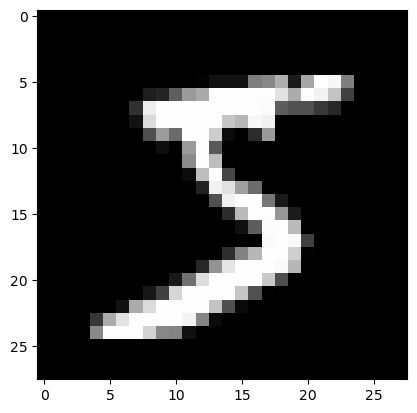

In [27]:
first_image_np = X_tr[0].reshape(28, 28)
first_image_label = Y_tr[0]
print(f'The first image in the training set is labeled "{first_image_label}."')
plt.imshow(first_image_np, cmap='gray')
plt.show()

# Logistic Regression

In [28]:
naive_logreg = LogisticRegression(max_iter=1, penalty=None, solver='saga') # sgd one epoch
time_start = time.time()
naive_logreg.fit(X_tr, Y_tr)
time_end = time.time()
preds = naive_logreg.predict(X_te)
acc = accuracy_score(Y_te, preds)
print(f'Naive linear model achieved {acc * 100}% accuracy in {time_end - time_start:.2f} seconds.')

Naive linear model achieved 92.02% accuracy in 2.37 seconds.


c:\Users\christian\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


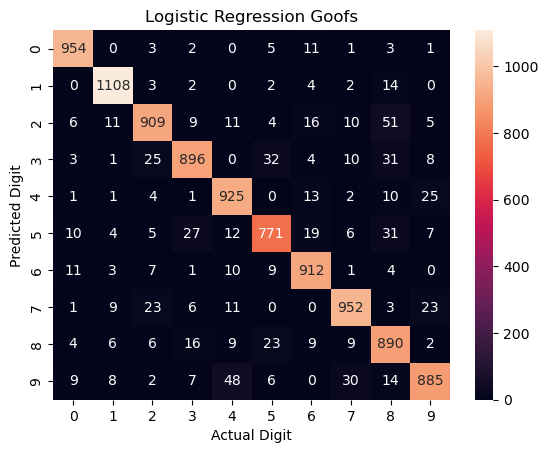

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(Y_te, preds)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Logistic Regression Goofs')
plt.xlabel('Actual Digit')
plt.ylabel('Predicted Digit')
plt.show()

# PCA, _then_ logistic regression
Now, let's try doing PCA on the data and seeing if that increases performance. The digits were originally 28x28; we'll try getting them down to 8x8 and seeing if that looks good.

In [30]:
from sklearn.decomposition import PCA
pca = PCA(n_components=64)
X_tr_pca = pca.fit_transform(X_tr)
X_te_pca = pca.transform(X_te)

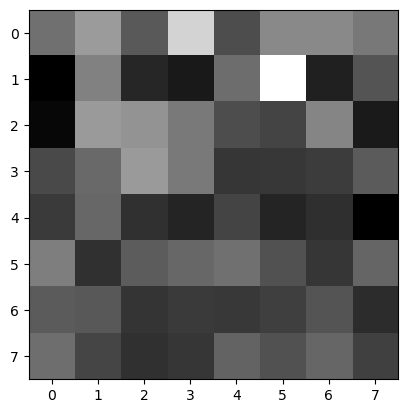

In [31]:
first_img_reduced_np = X_tr_pca[0].reshape(8, 8)
plt.imshow(first_img_reduced_np, cmap='gray')
plt.show()

In [32]:
naive_logreg_pca = LogisticRegression(max_iter=1, penalty=None, solver='saga')
time_start = time.time()
naive_logreg.fit(X_tr_pca, Y_tr)
time_end = time.time()
preds = naive_logreg.predict(X_te_pca)
acc = accuracy_score(Y_te, preds)
print(f'Linear model with PCA achieved {acc * 100}% accuracy in {time_end - time_start:.2f} seconds.')

Linear model with PCA achieved 91.24% accuracy in 0.19 seconds.


c:\Users\christian\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Reducing the dimension of the dataset _decreased_ the linear model's accuracy. (In all seriousness, I squished the images down to 8x8 to make a point, but 20x20 also didn't increase accuracy.)

# Convolutional Neural Network

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
torch.manual_seed(SEED)

In [34]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(7 * 7 * 32, 128)
        self.relu3 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 7 * 7 * 32)
        x = self.dropout(x)
        x = self.relu3(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [35]:
# reshaping to be in grids again to play nice with convolution
X_tr_pt = torch.from_numpy(X_tr.reshape(-1, 1, 28, 28)).float()
X_te_pt = torch.from_numpy(X_te.reshape(-1, 1, 28, 28)).float()
Y_tr_pt = torch.from_numpy(Y_tr)
Y_te_pt = torch.from_numpy(Y_te)

train_loader = DataLoader(TensorDataset(X_tr_pt, Y_tr_pt), batch_size=64, shuffle=True)
# test_loader = DataLoader(TensorDataset(X_te_pt, Y_te_pt), batch_size=64, shuffle=False)

In [36]:
LEARNING_RATE = 0.001
EPOCHS = 10

model = SimpleCNN()
crit = nn.CrossEntropyLoss()
adam = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_start = time.time()
for epoch in tqdm(range(EPOCHS)):
    ep_start = time.time()
    model.train()
    ep_loss = 0.0
    for x, y in train_loader:
        adam.zero_grad()
        preds = model(x)
        loss = crit(preds, y)
        loss.backward()
        adam.step()
        ep_loss += loss.item()

    ep_end = time.time()

    print(f'Epoch {epoch + 1}/{EPOCHS}: Loss = {ep_loss/len(train_loader):.2f} in {ep_end - ep_start:.2f}s')

train_end = time.time()

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10: Loss = 0.36 in 19.07s
Epoch 2/10: Loss = 0.13 in 18.07s
Epoch 3/10: Loss = 0.10 in 18.52s
Epoch 4/10: Loss = 0.08 in 20.41s
Epoch 5/10: Loss = 0.08 in 22.28s
Epoch 6/10: Loss = 0.07 in 21.71s
Epoch 7/10: Loss = 0.06 in 22.47s
Epoch 8/10: Loss = 0.06 in 23.75s
Epoch 9/10: Loss = 0.06 in 22.90s
Epoch 10/10: Loss = 0.05 in 22.17s


In [37]:
train_mins = int((train_end - train_start) // 60)
train_secs = int((train_end - train_start) % 60)
print(f'Finished training in {train_mins}:{train_secs}.')

Finished training in 3:31.


In [38]:
torch.save(model, 'CNN.pth')

In [45]:
loaded_model = torch.load('CNN.pth', weights_only=False)
loaded_model.eval()

with torch.no_grad():
    out = loaded_model(X_te_pt)
    _, preds = torch.max(out, 1)

In [47]:
model_acc = 100 * ((preds == Y_te_pt).sum().item() / len(preds)) # functional!
print(f'Model achieved {model_acc:.2f}% accuracy.')

Model achieved 99.13% accuracy.


Big improvement.

# Autoencoders

In [48]:
class Autoencoder_64(nn.Module):
    def __init__(self):
        super().__init__()
        # this is what "squishes"
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
        )
        
        # this is what "stretches"
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded =  self.decoder(encoded)
        return decoded
    
    # x is the numpy array, already flattened and normalized
    def fit(self, x, epochs=10, learning_rate=0.001, verbose=True):
        self.train()
        loader = DataLoader(torch.from_numpy(x).float(), batch_size=64, shuffle=True)
        adam = optim.Adam(self.parameters(), lr=learning_rate)
        crit = nn.MSELoss()
        train_start = time.time()
        for epoch in tqdm(range(epochs)):
            ep_start = time.time()
            ep_loss = 0.0
            for x in loader:
                adam.zero_grad()
                reconstructed = self(x)
                loss = crit(x, reconstructed)
                loss.backward()
                adam.step()
                ep_loss += loss.item()
            ep_end = time.time()
            if verbose:
                print(f'Epoch {epoch + 1}/{epochs}: Loss = {ep_loss/len(loader):.2f} in {ep_end - ep_start:.2f}s')
        train_end = time.time()
        if verbose:
            train_mins = int((train_end - train_start) // 60)
            train_secs = int((train_end - train_start) % 60)
            fname = 'ae_64.pth'
            print(f'Finished training in {train_mins}:{train_secs}.')
            print(f'Saving as {fname}.')
        torch.save(self, fname)
        return self

    # takes in and outputs numpy
    def transform(self, x):
        self.eval()
        with torch.no_grad():
            out = self.encoder(torch.from_numpy(x).float()).numpy()
        return out
    
    def fit_transform(self, x, epochs=10, learning_rate=0.001, verbose=True):
        self.fit(x, epochs=epochs, learning_rate=learning_rate, verbose=verbose)
        out = self.transform(x)
        return out
    
    def reconstruct(self, x):
        self.eval()
        with torch.no_grad():
            x_tensor = torch.from_numpy(x).float()
            out = self(x_tensor).numpy()
        return out

In [49]:
ae64 = Autoencoder_64()
transformed = ae64.fit_transform(X_tr)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10: Loss = 0.04 in 9.66s
Epoch 2/10: Loss = 0.02 in 9.67s
Epoch 3/10: Loss = 0.02 in 10.00s
Epoch 4/10: Loss = 0.01 in 10.11s
Epoch 5/10: Loss = 0.01 in 10.32s
Epoch 6/10: Loss = 0.01 in 10.17s
Epoch 7/10: Loss = 0.01 in 10.03s
Epoch 8/10: Loss = 0.01 in 10.27s
Epoch 9/10: Loss = 0.01 in 10.33s
Epoch 10/10: Loss = 0.01 in 13.23s
Finished training in 1:43.
Saving as ae_64.pth.


In [52]:
ae64 = torch.load('ae_64.pth', weights_only=False)
transformed = ae64.transform(X_tr)
reconstructed = ae64.reconstruct(X_tr)

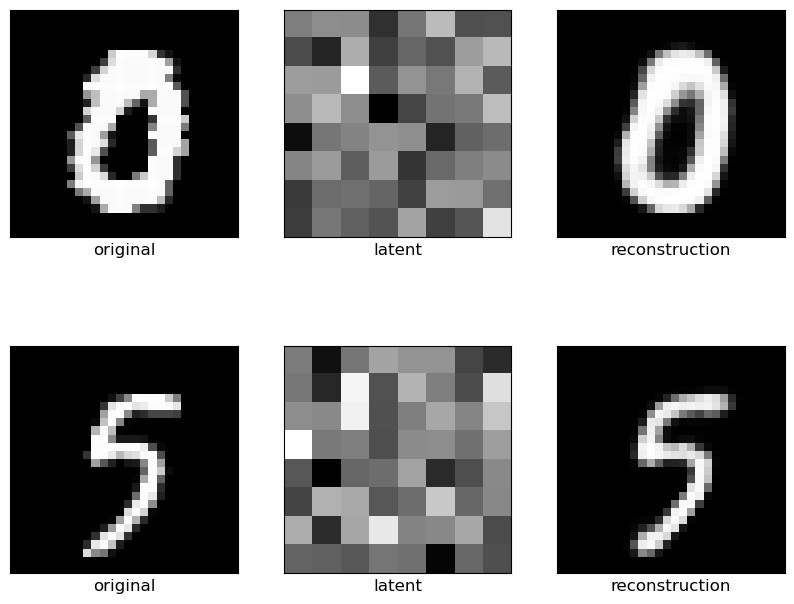

In [53]:
fig, axs = plt.subplots(2, 3, figsize=(10, 8))

for ax_row in axs:
    for ax in ax_row:
        ax.set_xticks([])
        ax.set_yticks([])

axs[0, 0].imshow(X_tr[69].reshape(28, 28), cmap='gray')
axs[0, 1].imshow(transformed[69].reshape(8, 8), cmap='gray')
axs[0, 2].imshow(reconstructed[69].reshape(28, 28), cmap='gray')
axs[1, 0].imshow(X_tr[420].reshape(28, 28), cmap='gray')
axs[1, 1].imshow(transformed[420].reshape(8, 8), cmap='gray')
axs[1, 2].imshow(reconstructed[420].reshape(28, 28), cmap='gray')

column_labels = ['original', 'latent', 'reconstruction']
for i in range(len(axs)):
    for ax, label in zip(axs[i], column_labels):
        ax.set_xlabel(label, fontsize=12)
plt.show()

In [55]:
from sklearn.decomposition import PCA
pca_64 = PCA(n_components=64)
pca_transformed = pca_64.fit_transform(X_tr)
pca_reconstructed = pca_64.inverse_transform(pca_transformed)

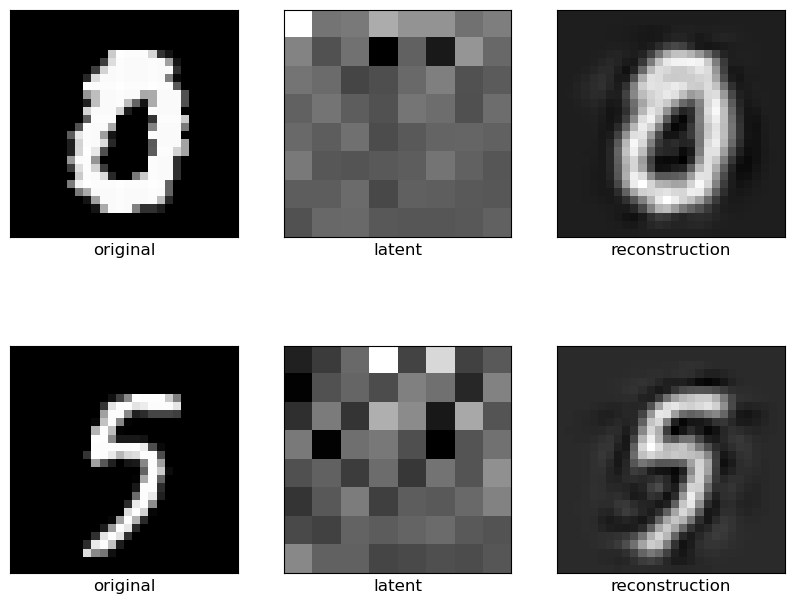

In [56]:
fig, axs = plt.subplots(2, 3, figsize=(10, 8))

for ax_row in axs:
    for ax in ax_row:
        ax.set_xticks([])
        ax.set_yticks([])

axs[0, 0].imshow(X_tr[69].reshape(28, 28), cmap='gray')
axs[0, 1].imshow(pca_transformed[69].reshape(8, 8), cmap='gray')
axs[0, 2].imshow(pca_reconstructed[69].reshape(28, 28), cmap='gray')
axs[1, 0].imshow(X_tr[420].reshape(28, 28), cmap='gray')
axs[1, 1].imshow(pca_transformed[420].reshape(8, 8), cmap='gray')
axs[1, 2].imshow(pca_reconstructed[420].reshape(28, 28), cmap='gray')

column_labels = ['original', 'latent', 'reconstruction']
for i in range(len(axs)):
    for ax, label in zip(axs[i], column_labels):
        ax.set_xlabel(label, fontsize=12)
plt.show()

Finally, let's see how well the linear classifier worked.

In [64]:
transform_start = time.time()
test_ae = ae64.transform(X_te)
transform_end = time.time()
ae_logreg = LogisticRegression(max_iter=1, penalty=None, solver='saga')
time_start = time.time()
ae_logreg.fit(transformed, Y_tr)
time_end = time.time()
ae_preds = ae_logreg.predict(test_ae)
acc = accuracy_score(Y_te, ae_preds)

c:\Users\christian\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [65]:
transform_time = transform_end - transform_start
lr_time = time_end - time_start
inf_time = transform_time + lr_time
print(f'Autoencoder transformed test set in {transform_end - transform_start:.2f} seconds.')
print(f'Autoencoder + linear model achieved {(acc * 100):.2f}% accuracy in {inf_time:.2f} seconds.')

Autoencoder transformed test set in 0.07 seconds.
Autoencoder + linear model achieved 93.12% accuracy in 0.30 seconds.
